# The Validation partition of the dataset

This notebook presents some of the common practices in training a classification model, namely:

- use of a validation set
- early stopping
- learning rate scheduler

# Auxiliary Function

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

In [2]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 32
EPOCHS = 20

cuda


In [4]:
PATH_TRAINING_SET = '../Aula4/dataset/train_full'
PATH_TEST_SET = '../Aula4/dataset/test'

In [5]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])


In [6]:
train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

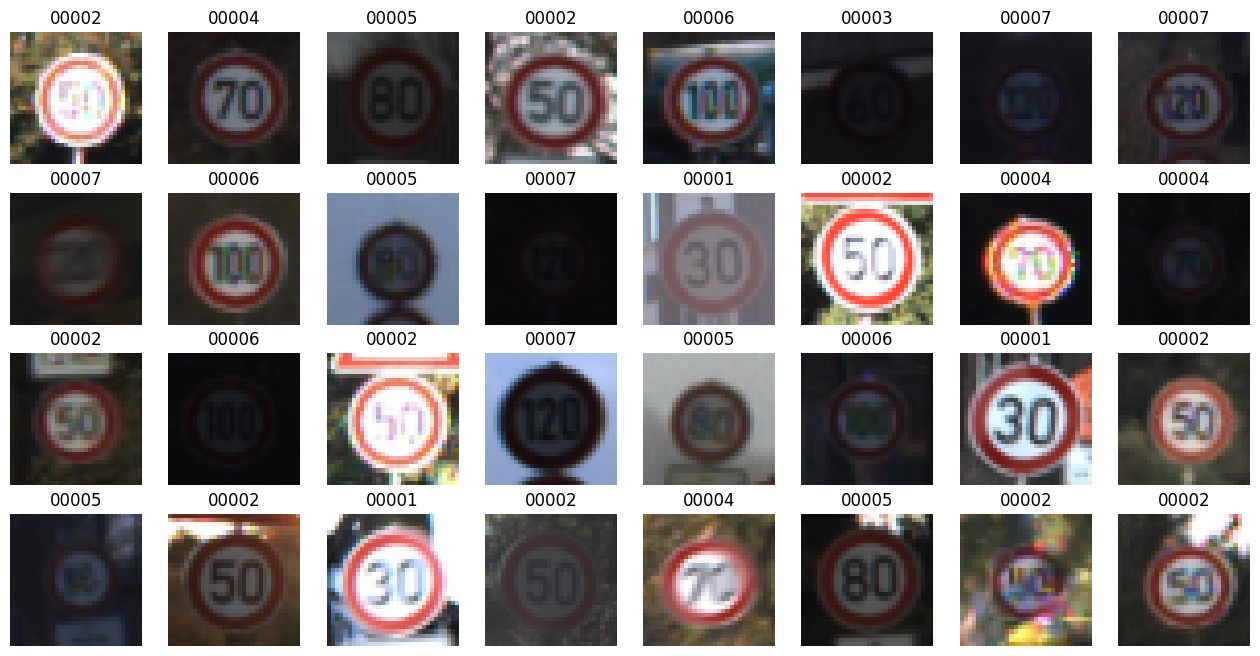

<Figure size 640x480 with 0 Axes>

In [7]:
images,targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,train_set.classes)

In [8]:
def train(model,data_loader,epochs,loss_function, optimizer):
    model.train()
    history={}
    history['accuracy'] = []
    history['loss'] = []
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0
        
        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_function(outputs,targets)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            _,pred = torch.max(outputs,1)
            correct += (pred == targets).sum()
            running_loss +=loss
        t_correct = 0
        for i,t in test_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)
            _,p = torch.max(o,1)
            t_correct += (p == t).sum()
        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f"Epoch {epoch:03d}, Accuracy: {accuracy:0.4f}, Loss: {running_loss:0.4f}, Accuracy_test = {100*t_correct/len(test_set)}, Time: {(stop_time-start_time):0.4f}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history

In [9]:
class Conv_II(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bm1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bm2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bm3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bm4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
    
    def forward(self, x):
        #input = (batch_size, 1, 28, 28)
        x = self.conv1(x) # -> (batch_size, 16, 30, 30)
        x = self.bm1(x)
        x = self.relu1(x) 

        x = self.conv2(x) # -> (batch_size, 32, 28, 28)
        x = self.bm2(x)
        x = self.relu2(x) 

        x = self.maxpool1(x) # -> (batch_size, 32, 14, 14)

        x = self.conv3(x) # -> (batch_size, 48, 12, 12)
        x = self.bm3(x)
        x = self.relu3(x)

        x = self.conv4(x) # -> (batch_size, 48, 10, 10)
        x = self.bm4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> (batch_size, 48, 5, 5)

        x = torch.flatten(x, 1) # -> (batch_size, 1200)
        x = self.fc1(x) # -> (batch_size, num_classes)
        return x
    
model_Conv_II = Conv_II(len(train_set.classes))
model_Conv_II.to(device)
print(model_Conv_II)
summary = torchinfo.summary(model_Conv_II, input_size = (BATCH_SIZE,3,32,32))
print(summary)


Conv_II(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
Conv

In [10]:
optimizer = torch.optim.Adam(model_Conv_II.parameters())
loss_function = torch.nn.CrossEntropyLoss()

history_I = train(model_Conv_II, train_loader, EPOCHS, loss_function, optimizer)

Epoch 000, Accuracy: 86.3928, Loss: 167.5813, Accuracy_test = 94.6282958984375, Time: 10.1685
Epoch 001, Accuracy: 99.1784, Loss: 14.9230, Accuracy_test = 96.54676055908203, Time: 9.4036
Epoch 002, Accuracy: 99.4210, Loss: 8.7888, Accuracy_test = 96.06714630126953, Time: 10.2288
Epoch 003, Accuracy: 99.8905, Loss: 2.6074, Accuracy_test = 97.52997589111328, Time: 9.3455
Epoch 004, Accuracy: 99.9452, Loss: 1.4919, Accuracy_test = 97.62590026855469, Time: 9.3844
Epoch 005, Accuracy: 100.0000, Loss: 0.4746, Accuracy_test = 97.7218246459961, Time: 9.2990
Epoch 006, Accuracy: 100.0000, Loss: 0.1573, Accuracy_test = 97.69784545898438, Time: 9.4428
Epoch 007, Accuracy: 100.0000, Loss: 0.1078, Accuracy_test = 97.553955078125, Time: 10.4550
Epoch 008, Accuracy: 100.0000, Loss: 0.0725, Accuracy_test = 97.6498794555664, Time: 10.3850
Epoch 009, Accuracy: 100.0000, Loss: 0.0971, Accuracy_test = 97.79376983642578, Time: 10.6895
Epoch 010, Accuracy: 98.1221, Loss: 27.0501, Accuracy_test = 97.79376983

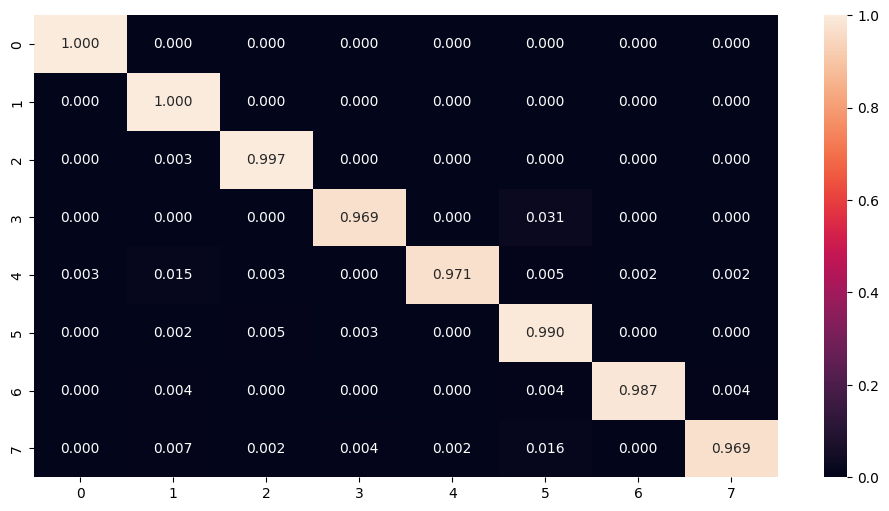

In [11]:
preds = []
ground_truth = []

model_Conv_II.eval()
for images, targets in test_loader:
    logits = model_Conv_II(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())
vcpi_util.show_confusion_matrix(ground_truth, preds, 8)

Counter({2: 2250, 1: 2220, 4: 1980, 5: 1860, 6: 1440, 3: 1410, 7: 1410, 0: 210})


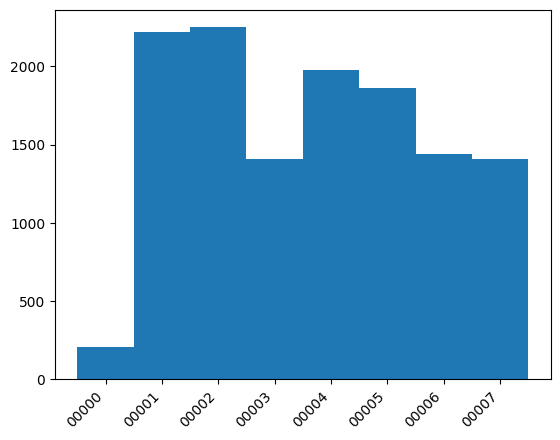

In [12]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)
vcpi_util.show_histogram(target_list, train_set.classes)

In [13]:
print(len(train_set))

12780


In [23]:
train_sub, val_sub = torch.utils.data.random_split(train_set, [10200, 2580])

In [24]:
train_sub_loader = torch.utils.data.DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
val_sub_loader = torch.utils.data.DataLoader(val_sub, batch_size=BATCH_SIZE)

In [28]:
def train(model,data_loader, val_sub_loader,epochs,loss_function, optimizer):
    model.train()
    
    history={}
    history['accuracy'] = []
    history['val_acc'] = []
    history['loss'] = []
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0
        
        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_function(outputs,targets)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            _,pred = torch.max(outputs,1)
            correct += (pred == targets).sum()
            running_loss +=loss
        t_correct = 0
        for i,t in val_sub_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)
            _,p = torch.max(o,1)
            t_correct += (p == t).sum()
        accuracy = 100 * correct / len(train_sub)
        val_accuracy = 100 * t_correct / len(val_sub)
        stop_time = time.time()
        print(f"Epoch {epoch:03d}, Accuracy: {accuracy:0.4f}, Loss: {running_loss:0.4f}, Accuracy_test = {100*t_correct/len(test_set)}, Val_acc: {val_accuracy:0.4f}, Time: {(stop_time-start_time):0.4f}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(val_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history

In [29]:
model_Conv_II = Conv_II(len(train_set.classes))
model_Conv_II.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer_II = torch.optim.Adam(model_Conv_II.parameters())

In [30]:
history_II = train(model_Conv_II, train_sub_loader, val_sub_loader, EPOCHS, loss_function, optimizer_II)

Epoch 000, Accuracy: 83.5588, Loss: 161.3318, Accuracy_test = 60.863311767578125, Val_acc: 98.3721, Time: 8.0848
Epoch 001, Accuracy: 98.9804, Loss: 15.0272, Accuracy_test = 60.959232330322266, Val_acc: 98.5271, Time: 7.6529
Epoch 002, Accuracy: 99.6765, Loss: 5.8333, Accuracy_test = 61.41486740112305, Val_acc: 99.2636, Time: 7.3243
Epoch 003, Accuracy: 99.8726, Loss: 2.8271, Accuracy_test = 61.24700164794922, Val_acc: 98.9922, Time: 7.5691
Epoch 004, Accuracy: 99.7843, Loss: 3.2693, Accuracy_test = 61.2709846496582, Val_acc: 99.0310, Time: 7.5212
Epoch 005, Accuracy: 99.9804, Loss: 0.8690, Accuracy_test = 61.53477096557617, Val_acc: 99.4574, Time: 7.3253
Epoch 006, Accuracy: 100.0000, Loss: 0.2625, Accuracy_test = 61.60671615600586, Val_acc: 99.5736, Time: 6.9206
Epoch 007, Accuracy: 100.0000, Loss: 0.1191, Accuracy_test = 61.67865753173828, Val_acc: 99.6899, Time: 7.0613
Epoch 008, Accuracy: 100.0000, Loss: 0.0864, Accuracy_test = 61.63069534301758, Val_acc: 99.6124, Time: 6.8212
Epo

In [31]:
evaluate(model_Conv_II, test_loader)

0.9904076457023621

In [32]:
PATH_VAL_SET = '../Aula4/dataset/val'
PATH_TRAIN_PARTIAL_SET = '../Aula4/dataset/train'

train_partial = torchvision.datasets.ImageFolder(root=PATH_TRAIN_PARTIAL_SET, transform=transform)
train_partial_loader = torch.utils.data.DataLoader(train_partial, batch_size=BATCH_SIZE, shuffle=True)

val_set = torchvision.datasets.ImageFolder(root=PATH_VAL_SET, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
model_Conv_III = Conv_II(len(train_partial.classes))
model_Conv_III.to(device)

optimizer_III = torch.optim.Adam(model_Conv_III.parameters())
history_III = train(model_Conv_III, train_partial_loader, val_loader, EPOCHS, loss_function, optimizer_III)

Epoch 000, Accuracy: 88.5098, Loss: 125.0509, Accuracy_test = 58.08153533935547, Val_acc: 93.8760, Time: 7.2839
Epoch 001, Accuracy: 99.3922, Loss: 11.3654, Accuracy_test = 59.040767669677734, Val_acc: 95.4264, Time: 7.3689
Epoch 002, Accuracy: 99.8235, Loss: 3.6671, Accuracy_test = 58.29736328125, Val_acc: 94.2248, Time: 7.0375
Epoch 003, Accuracy: 99.9804, Loss: 1.2893, Accuracy_test = 60.07194137573242, Val_acc: 97.0930, Time: 7.0763
Epoch 004, Accuracy: 99.9902, Loss: 0.4977, Accuracy_test = 60.0, Val_acc: 96.9767, Time: 6.9239
Epoch 005, Accuracy: 100.0000, Loss: 0.2105, Accuracy_test = 59.9520378112793, Val_acc: 96.8992, Time: 7.0434
Epoch 006, Accuracy: 100.0000, Loss: 0.1467, Accuracy_test = 60.23980712890625, Val_acc: 97.3643, Time: 7.3717
Epoch 007, Accuracy: 100.0000, Loss: 0.0988, Accuracy_test = 60.23980712890625, Val_acc: 97.3643, Time: 7.1194
Epoch 008, Accuracy: 100.0000, Loss: 0.0698, Accuracy_test = 60.19184875488281, Val_acc: 97.2868, Time: 7.6570
Epoch 009, Accuracy

In [34]:
class Early_Stopping():
    
    def __init__(self, patience = 3, min_delta = 0.00001):
        
        self.patience = patience
        self.min_delta = min_delta
        
        self.min_val_loss = float('inf')
        self.counter = 0
        
    def __call__(self, val_loss):
        
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
        
        return False

In [35]:
optimizer_aux = torch.optim.Adam(model_Conv_III.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.00001)

lrs = []

for epoch in range(50):
    
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


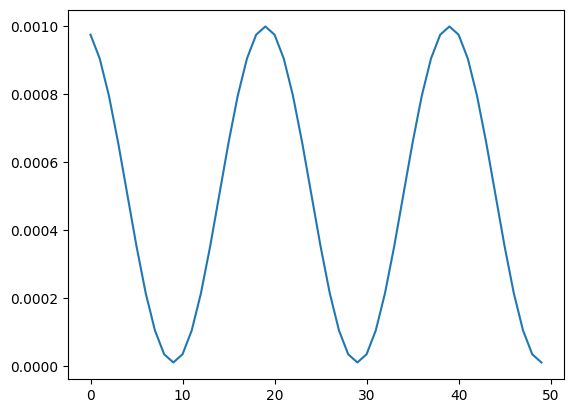

In [36]:
plt.plot(lrs)

In [37]:
def train(model,data_loader, val_sub_loader,epochs,loss_function, optimizer,
          scheduler, early_stopper, save_prefix = 'model'):
    
    history={}
    history['accuracy'] = []
    history['val_acc'] = []
    history['loss'] = []
    history['val_loss'] = []
    best_val_loss = np.inf
    
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0
        
        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_function(outputs,targets)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            _,pred = torch.max(outputs,1)
            correct += (pred == targets).sum()
            running_loss +=loss
        model.eval()
        t_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_sub_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                t_correct += (p == t).sum()
                
                val_loss += loss_function(o,t)
                
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print(f"Learning rate changed from {old_lr} to {new_lr}")
        
        accuracy = 100 * correct / len(train_sub)
        val_accuracy = 100 * t_correct / len(val_sub)
        val_loss = val_loss / len(val_sub)
        stop_time = time.time()
        print(f"Epoch {epoch:03d}, Accuracy: {accuracy:0.4f}, Loss: {running_loss:0.4f}, Accuracy_test = {100*t_correct/len(test_set)}, Val_acc: {val_accuracy:0.4f}, Time: {(stop_time-start_time):0.4f}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(val_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save( {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }, f'{save_prefix}.pt')
            
        if early_stopper(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
        
    return history

In [38]:
model_Conv_IV = Conv_II(len(train_set.classes))
model_Conv_IV.to(device)

optimizer_IV = torch.optim.Adam(model_Conv_IV.parameters())
scheduler_IV = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_IV, mode='min', factor=0.1, patience=3)

early_stopper = Early_Stopping(patience = 9)

In [39]:
history_IV = train(model_Conv_IV, train_partial_loader, val_loader, EPOCHS, loss_function, optimizer_IV, scheduler_IV, early_stopper, 'model_Conv_IV')

Epoch 000, Accuracy: 86.9510, Loss: 134.2433, Accuracy_test = 59.184654235839844, Val_acc: 95.6589, Time: 7.6384
Epoch 001, Accuracy: 99.3922, Loss: 9.6673, Accuracy_test = 59.040767669677734, Val_acc: 95.4264, Time: 7.1590
Epoch 002, Accuracy: 99.7255, Loss: 4.8847, Accuracy_test = 59.56834411621094, Val_acc: 96.2791, Time: 6.9746
Epoch 003, Accuracy: 99.9706, Loss: 1.1670, Accuracy_test = 58.92086410522461, Val_acc: 95.2326, Time: 7.0070
Epoch 004, Accuracy: 100.0000, Loss: 0.4687, Accuracy_test = 60.0, Val_acc: 96.9767, Time: 7.1738
Epoch 005, Accuracy: 100.0000, Loss: 0.2197, Accuracy_test = 60.38369369506836, Val_acc: 97.5969, Time: 7.4540
Epoch 006, Accuracy: 100.0000, Loss: 0.1380, Accuracy_test = 60.335731506347656, Val_acc: 97.5194, Time: 7.2254
Epoch 007, Accuracy: 100.0000, Loss: 0.0866, Accuracy_test = 60.52758026123047, Val_acc: 97.8295, Time: 7.3293
Epoch 008, Accuracy: 100.0000, Loss: 0.0724, Accuracy_test = 60.62350082397461, Val_acc: 97.9845, Time: 7.2523
Epoch 009, Ac

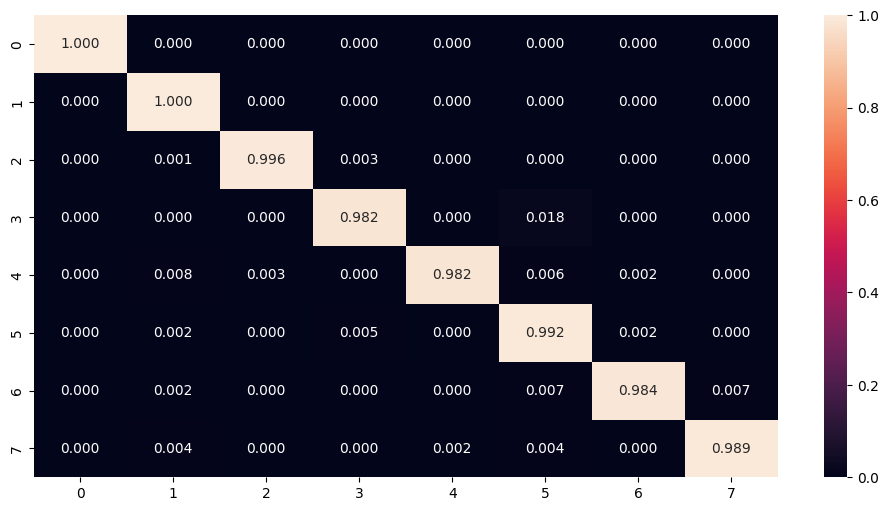

In [40]:
preds = []
ground_truth = []

model_Conv_IV.eval()
for images, targets in test_loader:
    logits = model_Conv_II(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())
vcpi_util.show_confusion_matrix(ground_truth, preds, 8)